In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy.stats as stat
import matplotlib.pyplot as plt

In [3]:
import scipy.optimize as optimize
import scipy.special as sp

In [4]:
from scipy.stats import norm
import matplotlib.mlab as mlab

In [5]:
from scipy.interpolate import interp1d
import statsmodels.api as sm

In [6]:
df = pd.read_csv('../Data_All_180906/CSV/Forecasting AI Progress v1.0.csv')

In [7]:
df.shape

(228, 43)

In [8]:
df = df.iloc[:,9:]

In [9]:
df.columns = ['name','surname','employer','job','Q1',
             'Q2','Q3','Q4','Q5a','Q5b','Q5c','Cq5','Q6a','Q6b',
             'Q6c','Cq6','Q7a','Q7b','Q7c','Q8a','Q8b','Q8c',
             'Cq7-8','Q9a','Q9b','Q9c','Q10a','Q10b','Q10c',
             'Cq9-10','Q11','Q12','Q13','Cq11-13']

In [10]:
#drop incomplete
df = df[df.iloc[:,-2].isnull() == False]
print(df.shape)

(166, 34)


In [11]:
df = df.dropna(subset=['name','surname','employer','job'])

## Total completed surveys

In [12]:
df.shape

(165, 34)

In [13]:
q1 = df.Q1
q2 = df.Q2
q3 = df.Q3
q4 = df.Q4
q5 = df[['Q5a','Q5b','Q5c']]
q6 = df[['Q6a','Q6b','Q6c']]
q7 = df[['Q7a','Q7b','Q7c']]
q8 = df[['Q8a','Q8b','Q8c']]
q9 = df[['Q9a','Q9b','Q9c']]
q10 = df[['Q10a','Q10b','Q10c']]
q11 = df.Q11
q12 = df.Q12
q13 = df.Q13

In [14]:
#drop locally incomplete
q5 = q5.dropna()

In [15]:
q5.shape

(165, 3)

In [16]:
q5 = q5.iloc[1:]
q5 = q5.astype(float)
q5.head()

,Q5a,Q5b,Q5c
1,50.0,69.0,95.0
3,69.0,46.0,79.0
4,20.0,35.0,80.0
5,60.0,85.0,90.0
6,10.0,15.0,20.0


#### Removing responses that did not change over time

In [17]:
q5 = q5[q5.Q5c-q5.Q5b >= 0.000001]
q5 = q5[q5.Q5c-q5.Q5a >= 0.000001]
q5 = q5[q5.Q5b-q5.Q5a >= 0.000001]
q5.shape[0]

139

## Master results

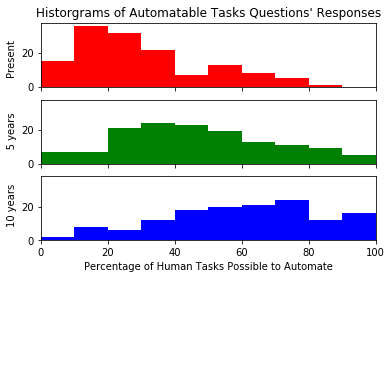

In [18]:
f1, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.set_title('Historgrams of Automatable Tasks Questions\' Responses')
n, bins, patches = ax1.hist(q5.Q5a,bins=10,range=(0,100),color='red')#'powderblue')
(mu, sigma) = norm.fit(q5.Q5a)
n, bins, patches = ax2.hist(q5.Q5b,bins=10,range=(0,100),color='green')#'skyblue')
plt.ylabel('                                                '+\
            '10 years           5 years           Present')
n, bins, patches = ax3.hist(q5.Q5c,bins=10,range=(0,100),color='blue')#'steelblue')
plt.xlim(0,100)
plt.xlabel('Percentage of Human Tasks Possible to Automate')
plt.savefig('PercentageTasksHistograms.png')
plt.show()

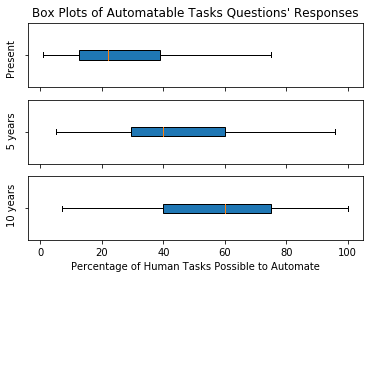

In [19]:
f1, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.set_title('Box Plots of Automatable Tasks Questions\' Responses')
ax1.boxplot(q5.Q5a.values,0,'rs',0,patch_artist=True,showfliers=False)
ax2.boxplot(q5.Q5b.values,0,'rs',0,patch_artist=True)
ax3.boxplot(q5.Q5c.values,0,'rs',0,patch_artist=True)
plt.xlabel('Percentage of Human Tasks Possible to Automate')

ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
plt.ylabel('                                                '+\
            '10 years           5 years           Present')
plt.savefig('PercentageTasksBoxplots.png')
plt.show()

In [20]:
print('mean automatable tasks now: ' + str(q5.Q5a.mean()))
print('median automatable tasks now: ' + str(q5.Q5a.median()))
#print('stdev automatable tasks now: ' + str(q5.Q5a.stdev()))
#HUGE AMOUNT OF VARIANCE - SHOW!!!

mean automatable tasks now: 27.345323741007196
median automatable tasks now: 22.0


In [21]:
print('mean automatable tasks 5yr: ' + str(q5.Q5b.mean()))
print('median automatable tasks 5yr: ' + str(q5.Q5b.median()))

mean automatable tasks 5yr: 44.31654676258993
median automatable tasks 5yr: 40.0


In [22]:
print('mean automatable tasks 10yr: ' + str(q5.Q5c.mean()))
print('median automatable tasks 10yr: ' + str(q5.Q5c.median()))

mean automatable tasks 10yr: 57.74820143884892
median automatable tasks 10yr: 60.0


# Statistical prep

In [23]:
dfx = pd.read_csv('../data_b.csv',keep_default_na=False)
df4 = dfx.iloc[:,7:]
df4.columns = ['role','demo','name','surname','employer','job','Q1',\
             'Q2','Q3','Q4','Q5a','Q5b','Q5c','Cq5','Q6a','Q6b',
             'Q6c','Cq6','Q7a','Q7b','Q7c','Q8a','Q8b','Q8c',
             'Cq7-8','Q9a','Q9b','Q9c','Q10a','Q10b','Q10c',
             'Cq9-10','Q11','Q12','Q13','Cq11-13','expert']
experts = df4.expert
demo = df4.demo
roles = df4.role
demo = np.asarray(demo)
roles = np.asarray(roles)
print(demo.shape)
print(roles.shape)
role = np.zeros(demo.shape[0]+1)
region = np.zeros(demo.shape[0]+1)
gender = np.zeros(demo.shape[0]+1)
experts = np.asarray(experts)
expert = np.zeros(demo.shape[0]+1)
for i in range(0,demo.shape[0]-1):
    try:
        vals = demo[i+1].split(',')
        #print (vals)
        if vals[0] == 'EU':
            region[i+1] = 0
        elif vals[0] == 'A':
            region[i+1] = 1
        elif vals[0] == 'NA':
            region[i+1] = 2
        elif vals[0] == 'O':
            region[i+1] = 3
        elif vals[0] == 'X':
            region[i+1] = -1
        elif vals[0] == 'SA':
            region[i+1] = 3
        elif vals[0] == 'AR':
            region[i+1] = 3
        else:
            region[i+1] = -1
            #print(vals[0])
        try:
            if vals[1] == 'f':
                gender[i+1] = 0
            else:
                gender[i+1] = 1
        except:
            gender[i+1] = 1
    except:
        region[i+1] = -1
        gender[i+1] = -1
    if roles[i+1] == 'phd': #grad student
        role[i+1] = 0
    elif roles[i+1] == 'prof': #academic
        role[i+1] = 1
    elif roles[i+1] == 'r': #industry research
        role[i+1] = 2
    elif roles[i+1] == 'eng': #industry engineer
        role[i+1] = 3
    elif roles[i+1] == 'exec': #industry executive
        role[i+1] = 4
    elif roles[i+1] == 'f': #founder
        role[i+1] = 5
    else: role[i+1] = -1
    if experts[i+1] == 'x' or experts[i+1] == 'na':
        expert[i+1] = -1
    else:
        expert[i+1] = 1
#expert_df = pd.DataFrame(expert)
#df['expert'] = expert_df
region_df = pd.DataFrame(region)
gender_df = pd.DataFrame(gender)
role_df = pd.DataFrame(role)
df['region'] = region_df
df['gender'] = gender_df
df['role'] = role_df

(230,)
(230,)


In [24]:
q5 = df[['Q5a','Q5b','Q5c','gender','region','role']]

In [25]:
q5['conf'] = q5.index
q5.conf[q5.index > 57] = 0
q5.conf[q5.index <= 57] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A valu

In [26]:
q5 = q5.iloc[1:,:]
q5 = q5.astype(float)

In [27]:
q5 = q5[q5.Q5c-q5.Q5b >= 0.000001]
q5 = q5[q5.Q5c-q5.Q5a >= 0.000001]
q5 = q5[q5.Q5b-q5.Q5a >= 0.000001]
q5.shape[0]

139

In [28]:
q5a = q5[['Q5a']]
q5b = q5[['Q5b']]
q5c = q5[['Q5c']]

In [29]:
q5a['student'] = pd.DataFrame(np.zeros((227,1)))
q5a['student'][q5['role'] == 0] = 1
q5b['student'] = pd.DataFrame(np.zeros((227,1)))
q5b['student'][q5['role'] == 0] = 1
q5c['student'] = pd.DataFrame(np.zeros((227,1)))
q5c['student'][q5['role'] == 0] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 


In [30]:
q5a['academic'] = pd.DataFrame(np.zeros((227,1)))
q5a['academic'][q5['role'] == 1] = 1
q5b['academic'] = pd.DataFrame(np.zeros((227,1)))
q5b['academic'][q5['role'] == 1] = 1
q5c['academic'] = pd.DataFrame(np.zeros((227,1)))
q5c['academic'][q5['role'] == 1] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 


In [31]:
q5a['scientist'] = pd.DataFrame(np.zeros((227,1)))
q5a['scientist'][q5['role'] == 2] = 1
q5b['scientist'] = pd.DataFrame(np.zeros((227,1)))
q5b['scientist'][q5['role'] == 2] = 1
q5c['scientist'] = pd.DataFrame(np.zeros((227,1)))
q5c['scientist'][q5['role'] == 2] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 


In [32]:
q5a['engineer'] = pd.DataFrame(np.zeros((227,1)))
q5a['engineer'][q5['role'] == 3] = 1
q5b['engineer'] = pd.DataFrame(np.zeros((227,1)))
q5b['engineer'][q5['role'] == 3] = 1
q5c['engineer'] = pd.DataFrame(np.zeros((227,1)))
q5c['engineer'][q5['role'] == 3] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 


In [33]:
q5a['executive'] = pd.DataFrame(np.zeros((227,1)))
q5a['executive'][q5['role'] == 4] = 1
q5b['executive'] = pd.DataFrame(np.zeros((227,1)))
q5b['executive'][q5['role'] == 4] = 1
q5c['executive'] = pd.DataFrame(np.zeros((227,1)))
q5c['executive'][q5['role'] == 4] = 1

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 


In [34]:
q5a['founder'] = pd.DataFrame(np.zeros((227,1)))
q5a['founder'][q5['role'] == 5] = 1
q5b['founder'] = pd.DataFrame(np.zeros((227,1)))
q5b['founder'][q5['role'] == 5] = 1
q5c['founder'] = pd.DataFrame(np.zeros((227,1)))
q5c['founder'][q5['role'] == 5] = 1

In [35]:
q5a['europe'] = pd.DataFrame(np.zeros((227,1)))
q5a['europe'][q5['region'] == 0] = 1
q5b['europe'] = pd.DataFrame(np.zeros((227,1)))
q5b['europe'][q5['region'] == 0] = 1
q5c['europe'] = pd.DataFrame(np.zeros((227,1)))
q5c['europe'][q5['region'] == 0] = 1

In [36]:
q5a['NA'] = pd.DataFrame(np.zeros((227,1)))
q5a['NA'][q5['region'] == 1] = 1
q5b['NA'] = pd.DataFrame(np.zeros((227,1)))
q5b['NA'][q5['region'] == 1] = 1
q5c['NA'] = pd.DataFrame(np.zeros((227,1)))
q5c['NA'][q5['region'] == 1] = 1

In [37]:
q5a['asia'] = pd.DataFrame(np.zeros((227,1)))
q5a['asia'][q5['region'] == 2] = 1
q5b['asia'] = pd.DataFrame(np.zeros((227,1)))
q5b['asia'][q5['region'] == 2] = 1
q5c['asia'] = pd.DataFrame(np.zeros((227,1)))
q5c['asia'][q5['region'] == 2] = 1

In [38]:
q5a['conf'] = q5['conf']
q5b['conf'] = q5['conf']
q5c['conf'] = q5['conf']

In [39]:
q5a['gender'] = pd.DataFrame(np.zeros((227,1)))
q5a['gender'][q5['gender'] == 0] = 1
q5b['gender'] = pd.DataFrame(np.zeros((227,1)))
q5b['gender'][q5['gender'] == 0] = 1
q5c['gender'] = pd.DataFrame(np.zeros((227,1)))
q5c['gender'][q5['gender'] == 0] = 1

In [40]:
q5a = q5a.iloc[:,:]
q5a

,Q5a,student,academic,scientist,engineer,executive,founder,europe,NA,asia,conf,gender
1,50.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,20.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,60.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,10.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,50.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
219,29.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
221,22.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
223,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
q5b = q5b.iloc[:,:]
q5b

,Q5b,student,academic,scientist,engineer,executive,founder,europe,NA,asia,conf,gender
1,69.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,35.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,85.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,15.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,50.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,60.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
219,51.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
221,33.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
223,40.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
q5c = q5c.iloc[:,:]
q5c

,Q5c,student,academic,scientist,engineer,executive,founder,europe,NA,asia,conf,gender
1,95.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,80.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5,90.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6,20.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,75.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
216,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
219,81.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
221,40.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
223,55.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
q5a.to_csv('q5a.csv')

In [44]:
q5b.to_csv('q5b.csv')

In [45]:
q5c.to_csv('q5c.csv')